In [ ]:
from heapq import heapify, heappop, heappush, heappushpop
from sklearn.utils import check_array
from sklearn.utils.validation import check_memory
from sklearn.cluster import _hierarchical_fast as _hierarchical
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.cluster.hierarchy as sch
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import Birch
import numpy as np
from scipy import sparse
from sklearn.cluster import AgglomerativeClustering, Birch
from sklearn.utils.extmath import row_norms, safe_sparse_dot
from sklearn.utils.validation import check_is_fitted

## Data

In [ ]:
data = pd.read_csv('q1a.csv')
data.head()

,A,B,C,D,E,F
0,0.00,0.71,5.66,3.61,4.24,3.20
1,0.71,0.00,4.95,2.92,3.54,2.50
2,5.66,4.95,0.00,2.24,1.41,2.50
3,3.61,2.92,2.24,0.00,1.00,0.50
4,4.24,3.54,1.41,1.00,0.00,1.12


In [ ]:
data_2 = pd.read_excel('matrix.xlsx', header=None)
data_2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,0.154530,0.067232,0.114163,0.119520,0.352498,0.002196,0.463378,0.456631,0.422190,0.230062,0.001864,0.214656,0.091797,0.412021,0.367051,0.436423,0.035959,0.024758,0.035581,0.113957,0.097003,0.089424,0.720883,0.393053,0.285390,0.744426,0.081614,0.021957,0.075406,0.025881
1,0.067232,0.210769,0.230892,0.241605,0.048367,0.192809,0.371816,0.136878,0.652689,0.128090,0.255947,0.044213,0.737641,0.243757,0.048467,0.182598,0.001851,0.501345,0.064597,0.216244,0.354133,0.302550,0.295841,0.202220,0.029919,0.238655,0.087508,0.312674,0.362604,0.076289
2,0.114163,0.230892,0.766893,0.017749,0.131733,0.049124,0.174170,0.394250,0.126765,0.121102,0.105133,0.002578,0.378258,0.422101,0.123942,0.255028,0.090608,0.052193,0.007113,0.031958,0.146560,0.155150,0.081890,0.140633,0.196814,0.015781,0.291977,0.677837,0.194241,0.967901
3,0.119520,0.241605,0.017749,0.057910,0.007232,0.018638,0.019790,0.041866,0.052705,0.162619,0.482486,0.089332,0.293531,0.629935,0.300723,0.010842,0.328028,0.377447,0.568194,0.012107,0.487177,0.326593,0.025012,0.206512,0.121218,0.474819,0.620548,0.101567,0.249203,0.041609
4,0.352498,0.048367,0.131733,0.007232,0.202976,0.531130,0.109825,0.168321,0.061196,0.044006,0.005062,0.350172,0.570985,0.155927,0.063263,0.240097,0.258672,0.000974,0.212851,0.076594,0.359286,0.182394,0.075757,0.016475,0.112069,0.326651,0.127287,0.180572,0.360499,0.213463


## Utility Functions

In [ ]:
def _hc_cut(n_clusters, children, n_leaves):
    nodes = [-(max(children[-1]) + 1)]
    for _ in range(n_clusters - 1):
        these_children = children[-nodes[0] - n_leaves]
        heappush(nodes, -these_children[0])
        heappushpop(nodes, -these_children[1])
    label = np.zeros(n_leaves, dtype=np.intp)
    for i, node in enumerate(nodes):
        label[_hierarchical._hc_get_descendent(-node, children, n_leaves)] = i
    return label

In [ ]:
def linkage_tree(X, connectivity=None, n_clusters=None, linkage='average',
                 affinity="precomputed", return_distance=False):
    X = np.asarray(X)
    if X.ndim == 1:
        X = np.reshape(X, (-1, 1))
    n_samples, n_features = X.shape

    linkage_choices = {'average': _hierarchical.average_merge}
    join_func = linkage_choices[linkage]

    if connectivity is None:
        from scipy.cluster import hierarchy
        if affinity == 'precomputed':
            i, j = np.triu_indices(X.shape[0], k=1)
            X = X[i, j]
        out = hierarchy.linkage(X, method=linkage, metric=affinity)
        children_ = out[:, :2].astype(np.int, copy=False)

        if return_distance:
            distances = out[:, 2]
            return children_, 1, n_samples, None, distances
        return children_, 1, n_samples, None

    connectivity, n_connected_components = _fix_connectivity(
                                                X, connectivity,
                                                affinity=affinity)
    connectivity = connectivity.tocoo()
    diag_mask = (connectivity.row != connectivity.col)
    connectivity.row = connectivity.row[diag_mask]
    connectivity.col = connectivity.col[diag_mask]
    connectivity.data = connectivity.data[diag_mask]
    del diag_mask

    if affinity == 'precomputed':
        distances = X[connectivity.row, connectivity.col].astype(
            'float64', **_astype_copy_false(X))
    connectivity.data = distances

    if n_clusters is None:
        n_nodes = 2 * n_samples - 1
    else:
        assert n_clusters <= n_samples
        n_nodes = 2 * n_samples - n_clusters

    if return_distance:
        distances = np.empty(n_nodes - n_samples)
    A = np.empty(n_nodes, dtype=object)
    inertia = list()

    connectivity = connectivity.tolil()
    for ind, (data, row) in enumerate(zip(connectivity.data,
                                          connectivity.rows)):
        A[ind] = IntFloatDict(np.asarray(row, dtype=np.intp),
                              np.asarray(data, dtype=np.float64))
        inertia.extend(_hierarchical.WeightedEdge(d, ind, r)
                       for r, d in zip(row, data) if r < ind)
    del connectivity

    heapify(inertia)

    parent = np.arange(n_nodes, dtype=np.intp)
    used_node = np.ones(n_nodes, dtype=np.intp)
    children = []

    for k in range(n_samples, n_nodes):
        while True:
            edge = heappop(inertia)
            if used_node[edge.a] and used_node[edge.b]:
                break
        i = edge.a
        j = edge.b

        if return_distance:
            distances[k - n_samples] = edge.weight

        parent[i] = parent[j] = k
        children.append((i, j))
        n_i = used_node[i]
        n_j = used_node[j]
        used_node[k] = n_i + n_j
        used_node[i] = used_node[j] = False

        coord_col = join_func(A[i], A[j], used_node, n_i, n_j)
        for l, d in coord_col:
            A[l].append(k, d)
            heappush(inertia, _hierarchical.WeightedEdge(d, k, l))
        A[k] = coord_col
        A[i] = A[j] = 0
    n_leaves = n_samples
    children = np.array(children)[:, ::-1]

    if return_distance:
        return children, n_connected_components, n_leaves, parent, distances
    return children, n_connected_components, n_leaves, parent

In [ ]:
def _average_linkage(*args, **kwargs):
    kwargs['linkage'] = 'average'
    return linkage_tree(*args, **kwargs)

In [ ]:
_TREE_BUILDERS = dict(average=_average_linkage)

## Main Class

In [ ]:
class HierarchialClustering:

    def __init__(self, n_clusters=2, affinity="precomputed",
                 memory=None,
                 connectivity=None, compute_full_tree='auto',
                 linkage='average', distance_threshold=None):
        self.n_clusters = n_clusters
        self.distance_threshold = distance_threshold
        self.memory = memory
        self.connectivity = connectivity
        self.compute_full_tree = compute_full_tree
        self.linkage = linkage
        self.affinity = affinity
        
    def n_components_(self):
        return self.n_connected_components_

    def fit(self, X, y=None):
        X = check_array(X, ensure_min_samples=2, estimator=self)
        memory = check_memory(self.memory)

        tree_builder = _TREE_BUILDERS[self.linkage]

        connectivity = self.connectivity
        if self.connectivity is not None:
            if callable(self.connectivity):
                connectivity = self.connectivity(X)
            connectivity = check_array(
                connectivity, accept_sparse=['csr', 'coo', 'lil'])

        n_samples = len(X)
        compute_full_tree = self.compute_full_tree
        if self.connectivity is None:
            compute_full_tree = True
        if compute_full_tree == 'auto':
            if self.distance_threshold is not None:
                compute_full_tree = True
            else:
                compute_full_tree = self.n_clusters < max(100, .02 * n_samples)
        n_clusters = self.n_clusters
        if compute_full_tree:
            n_clusters = None

        kwargs = {}
        if self.linkage != 'ward':
            kwargs['linkage'] = self.linkage
            kwargs['affinity'] = self.affinity

        distance_threshold = self.distance_threshold

        return_distance = distance_threshold is not None
        out = memory.cache(tree_builder)(X, connectivity,
                                         n_clusters=n_clusters,
                                         return_distance=return_distance,
                                         **kwargs)
        (self.children_,
         self.n_connected_components_,
         self.n_leaves_,
         parents) = out[:4]

        if return_distance:
            self.distances_ = out[-1]
            self.n_clusters_ = np.count_nonzero(
                self.distances_ >= distance_threshold) + 1
        else:
            self.n_clusters_ = self.n_clusters

        if compute_full_tree:
            self.labels_ = _hc_cut(self.n_clusters_, self.children_,
                                   self.n_leaves_)
        else:
            labels = _hierarchical.hc_get_heads(parents, copy=False)
            labels = np.copy(labels[:n_samples])
            self.labels_ = np.searchsorted(np.unique(labels), labels)
        return self

    def get_labels(self):
      return self.labels_

## Q1

In [ ]:
hc = HierarchialClustering(n_clusters=2, affinity='precomputed', linkage='average')
y_hc = hc.fit(data)

In [ ]:
y_hc.get_labels()

array([1, 1, 0, 0, 0, 0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


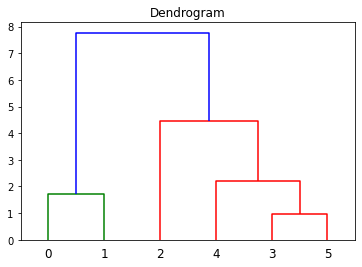

In [ ]:
dendrogram = sch.dendrogram(sch.linkage(data, method='average'))

plt.title('Dendrogram')
plt.show()

As we can see the clusters are correctly mapped

## Q2

In [ ]:
hc = HierarchialClustering(n_clusters=7, affinity='precomputed', linkage='average')
y_hc = hc.fit(data_2)

In [ ]:
y_hc.get_labels()

array([4, 0, 6, 2, 2, 1, 2, 5, 5, 1, 4, 6, 1, 0, 0, 1, 0, 2, 3, 6, 0, 4,
       3, 6, 5, 1, 5, 3, 4, 5])

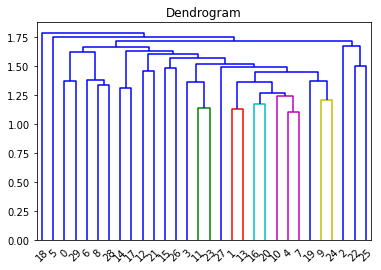

In [ ]:
dendrogram = sch.dendrogram(sch.linkage(data_2, method='average'))

plt.title('Dendrogram')
plt.show()